# Необычные модели Playboy, или про обнаружение выбросов в данных c помощью Scikit-learn
#### Автор материала: преподаватель Факультета Компьютерных Наук НИУ ВШЭ Кашницкий Юрий

## Загрузка и первичный анализ данных

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import scale
from sklearn import svm
from scipy import stats
from sklearn.decomposition import PCA

Populating the interactive namespace from numpy and matplotlib


**Считываем данные по моделям Playboy.**

In [2]:
girls = pd.read_csv('data/girls.csv', header=0)

**Процент "выбросов", задаваемый пользователем. Ищем 1% выбросов в данных, то есть ограничимся 6-7 «странными» девушками. (Переменные в Python, записанные в верхнем регистре, символизируют константы и обычно записываются в начале файла после подключения модулей).**

In [3]:
OUTLIER_FRACTION = 0.01

**Посмотрим общую статистику девушек.**

In [4]:
girls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 604 entries, 0 to 603
Data columns (total 7 columns):
Month     604 non-null object
Year      604 non-null int64
Bust      604 non-null int64
Waist     604 non-null int64
Hips      604 non-null int64
Height    604 non-null int64
Weight    604 non-null int64
dtypes: int64(6), object(1)
memory usage: 37.8+ KB


**Дальше узнаем про девушек побольше.**

In [5]:
girls.describe()

,Year,Bust,Waist,Hips,Height,Weight
count,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000
mean,1983.057947,89.293046,59.529801,87.942053,167.887417,52.168874
std,14.843740,3.994011,3.616909,3.479142,5.776711,4.040585
min,1953.000000,81.000000,46.000000,61.000000,150.000000,42.000000
25%,1970.000000,86.000000,58.000000,86.000000,165.000000,49.000000
50%,1983.000000,89.000000,61.000000,89.000000,168.000000,52.000000
75%,1996.000000,91.000000,61.000000,91.000000,173.000000,54.000000
max,2009.000000,104.000000,89.000000,99.000000,188.000000,68.000000


**Посмотрим на выбросы, которые бросаются в глаза.**

In [6]:
girls[girls['Waist'] == 89]

,Month,Year,Bust,Waist,Hips,Height,Weight
483,December,1998,86,89,86,173,52


**Для красоты можно еще построить и гистограммы распределения параметров девушек.**

**Распределение охвата груди.**

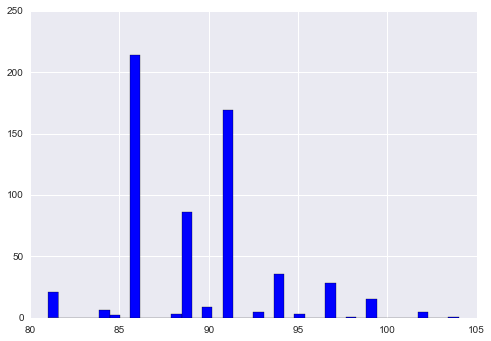

In [7]:
girls['Bust'].hist(bins=40, facecolor='blue', label="Bust")

**Распределение охвата талии.**

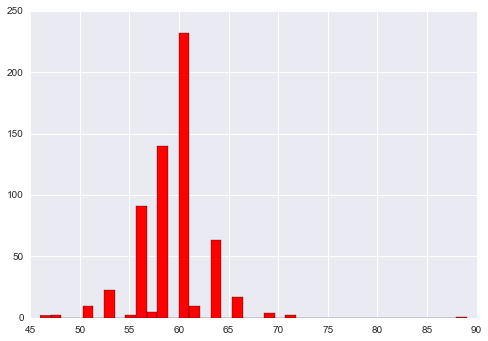

In [8]:
girls['Waist'].hist(bins=40, label="Waist", facecolor='red')

**Распределение охвата бедер.**

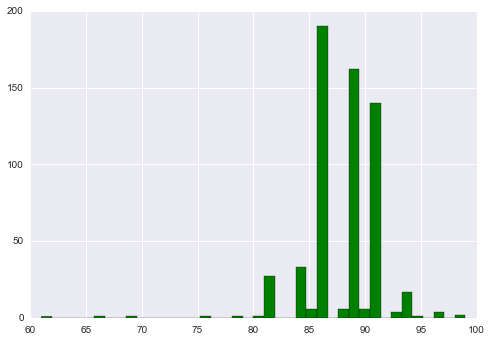

In [9]:
girls['Hips'].hist(bins=40, label="Hips", facecolor='green')

**Распределение роста.**

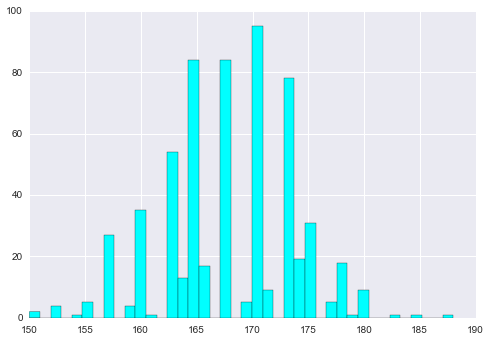

In [10]:
girls['Height'].hist(bins=40, label="Height", facecolor='cyan')

**Распределение веса.**

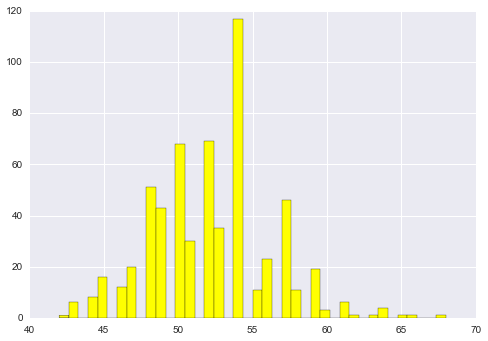

In [11]:
girls['Weight'].hist(bins=40, label="Weight", facecolor='yellow')

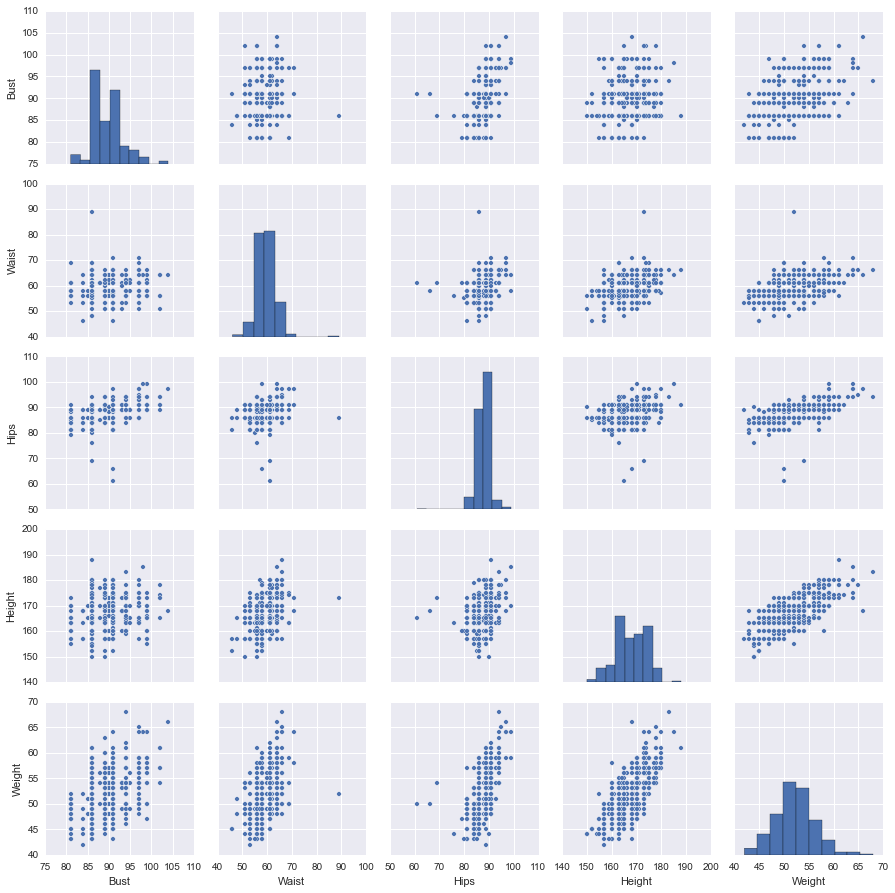

In [12]:
sns.pairplot(girls[['Bust', 'Waist', 'Hips', 'Height', 'Weight']])

## Предобработка данных

**Убираем признаки `месяц` и `год`.**

In [13]:
girl_params = np.array(girls.values[:,2:], dtype="float64")

**Шкалируем данные.**

In [14]:
girl_params = scale(girl_params) 

**Выделяем в них две главные компоненты.**

In [15]:
X = PCA(n_components=2).fit_transform(girl_params)

## Обучение модели

**Для обнаружения «выбросов» в данных используем одноклассовую машину опорных векторов. 
Создаем SVM классификатор с гауссовым ядром.**

In [16]:
svm_clf = svm.OneClassSVM(kernel="rbf")

**"Скармливаем" ему данные.**

In [17]:
svm_clf.fit(X)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

**В результате обучения алгоритма получаем вектор
индикаторов, является ли объект "выбросом".**

## Поиск выбросов

In [18]:
dist_to_border = svm_clf.decision_function(X).ravel()
threshold = stats.scoreatpercentile(dist_to_border,
            100 * OUTLIER_FRACTION)
is_outlier = dist_to_border < threshold

## Отображение и трактовка результатов

**Визуализация.**

(-7, 7)

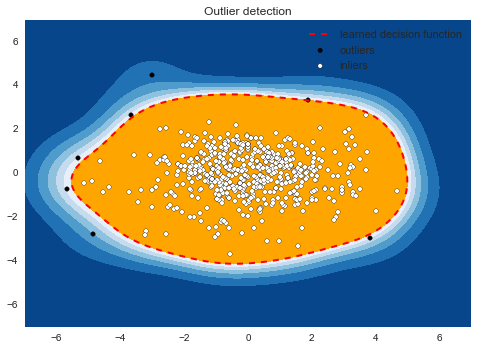

In [19]:
girls_num = girl_params.shape[0]
xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500))
n_inliers = int((1. - OUTLIER_FRACTION) * girls_num)
n_outliers = int(OUTLIER_FRACTION * girls_num)
Z = svm_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.title("Outlier detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
b = plt.scatter(X[is_outlier, 0], X[is_outlier, 1], c='black')
c = plt.scatter(X[is_outlier == 0, 0], X[is_outlier == 0, 1], c='white')
plt.axis('tight')
plt.legend([a.collections[0], b, c],
           ['learned decision function', 'outliers', 'inliers'],
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlim((-7, 7))
plt.ylim((-7, 7))

**Смотрим на "выбросы" - девушек с параметрами, отличающимися от средних.**

In [20]:
girls[is_outlier]

,Month,Year,Bust,Waist,Hips,Height,Weight
54,September,1962,91,46,86,152,45
67,October,1963,94,66,94,183,68
79,October,1964,104,64,97,168,66
173,September,1972,98,64,99,185,64
483,December,1998,86,89,86,173,52
507,December,2000,86,66,91,188,61
535,April,2003,86,61,69,173,54


 - Мики Уинтерс. Сентябрь, 1962. 91-46-86, рост 152, вес 45. 
 
<img src="img/girl1.jpg">

- Кристин Уильямс. Октябрь, 1963. 94-66-94, рост 183, вес 68.

<img src="img/girl2.jpg">

- Розмари Хилкрест. Октябрь, 1964. 104-64-97, рост 168, вес 66.

<img src="img/girl3.jpg">

- Сюзан Миллер. Сентябрь, 1972. 98-64-99, рост 185, вес 64.

<img src="img/girl4.jpg">

- Тройняшки Дам. 86-89 (реально 64)-86, рост 173, вес 52. 

<img src="img/girl5.jpg">

- Кара Мишель. Декабрь, 2000. 86-66-91, рост 188, вес 61.

<img src="img/girl6.jpg">

- Кармелла де Сезаре. Апрель, 2003. 86-61-69, рост 173, вес 54. 

<img src="img/girl7.jpg">

## Ссылки
- Материал этой тетрадки в <a href="http://habrahabr.ru/post/251225/">статье</a> на Хабрахабре
- <a href="http://scikit-learn.org/stable/auto_examples/covariance/plot_outlier_detection.html#example-covariance-plot-outlier-detection-py">Пример</a> Sklearn на обнаружение выбросов в синтетических данных
- <a href="http://habrahabr.ru/post/264407/">Статья</a> на Хабрахабре про поиск недооцененных квартир
- [Статья](https://habrahabr.ru/post/275963/) "Python и красивые ножки: как я бы знакомил сына с математикой и программированием" на Хабрахабре
- [Статья](https://habrahabr.ru/post/270449/) "Некоторые репозитории в помощь изучающим и преподающим Python и машинное обучение" на Хабрахабре
- [Курс](https://github.com/Yorko/python_intro) Python, основных алгоритмов и структур данных в виде тетрадок IPython
- [Статья](https://habrahabr.ru/company/mlclass/blog/252743/) "Ваш персональный курс по Big Data" на Хабрахабре